In [1]:
%matplotlib inline
import numpy as np
import sklearn.datasets as data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb; sb.set_style( 'darkgrid' ) # use whitegrid if prefer a white background
import pandas as pd

from numpy.random import SeedSequence, default_rng
rng = default_rng( SeedSequence().entropy )

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams.update( { 'font.size': 18 } ) # Use this to setup your preferred font size for plotting

#### 1- How sensitive PCA and ICA are to the number of observations? What changes the most in both PCA and ICA

In [2]:
from sklearn.decomposition import PCA, FastICA

np_rng = np.random.RandomState( 42 )
S      = np_rng.standard_t(1.5, size=(20006, 2)) # Student t Distribution
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

# Generate observations by computing the matrix product SA^T
X = np.dot(S, A.T)  

pca    = PCA()
S_pca_ = pca.fit(X).transform(X)

ica    = FastICA(random_state=rng.integers( 42 ) )
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

# Scale row-wise using standard deviation of S_ica_
S_ica_ /= S_ica_.std(axis=0)

In [3]:
def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01,
                       scale=6, color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

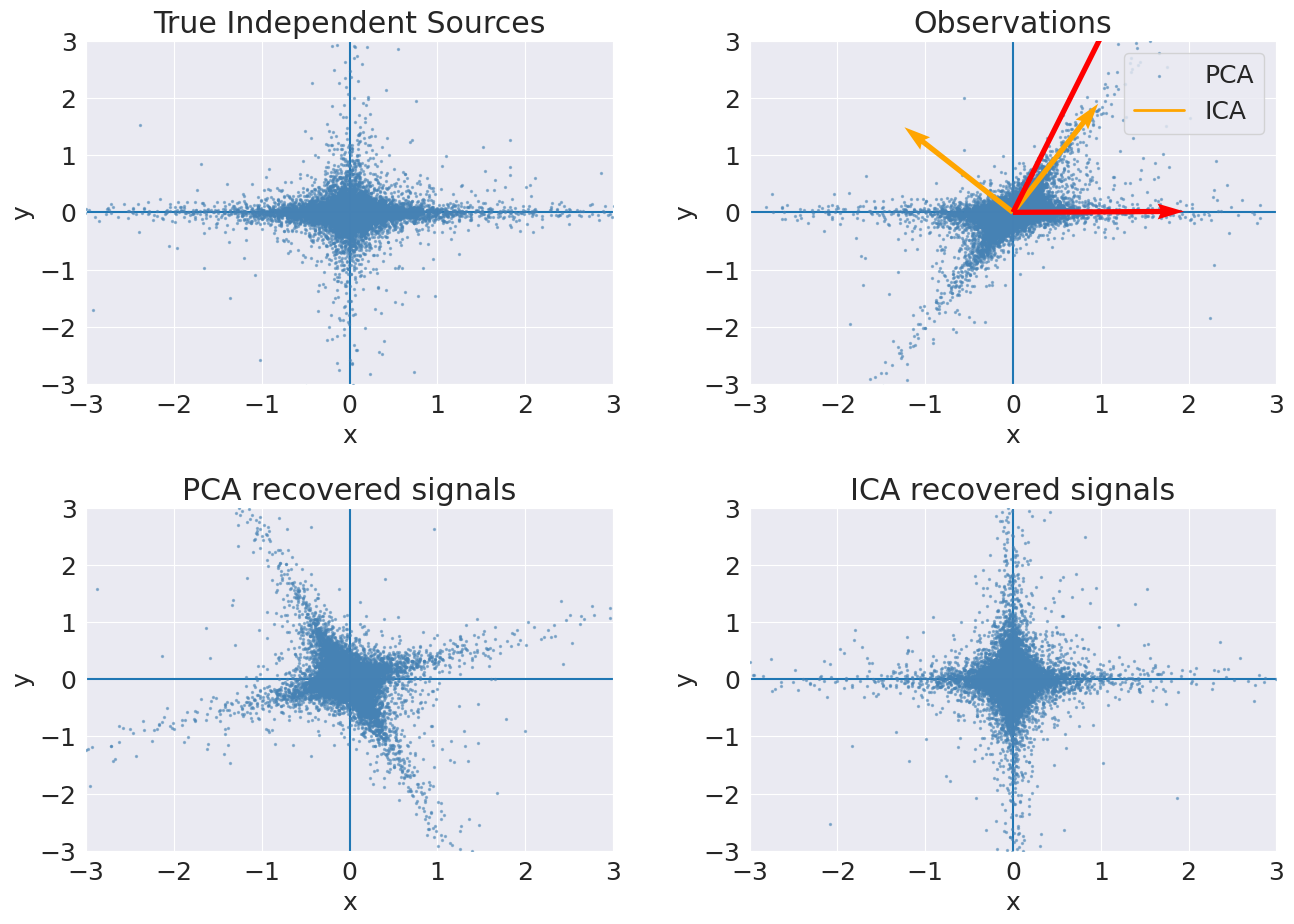

In [4]:
plt.figure( figsize = ( 14, 9 ) )
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

# PCA components and ICA mixing components
axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

#### 2- Use Non negative matrix factorization and Latent Dirichlet Allocation to group a collection of words into set topics (that is clusters). Experiment with different hyperparameters and also different number of features, sample sizes, top words and batch sizes.

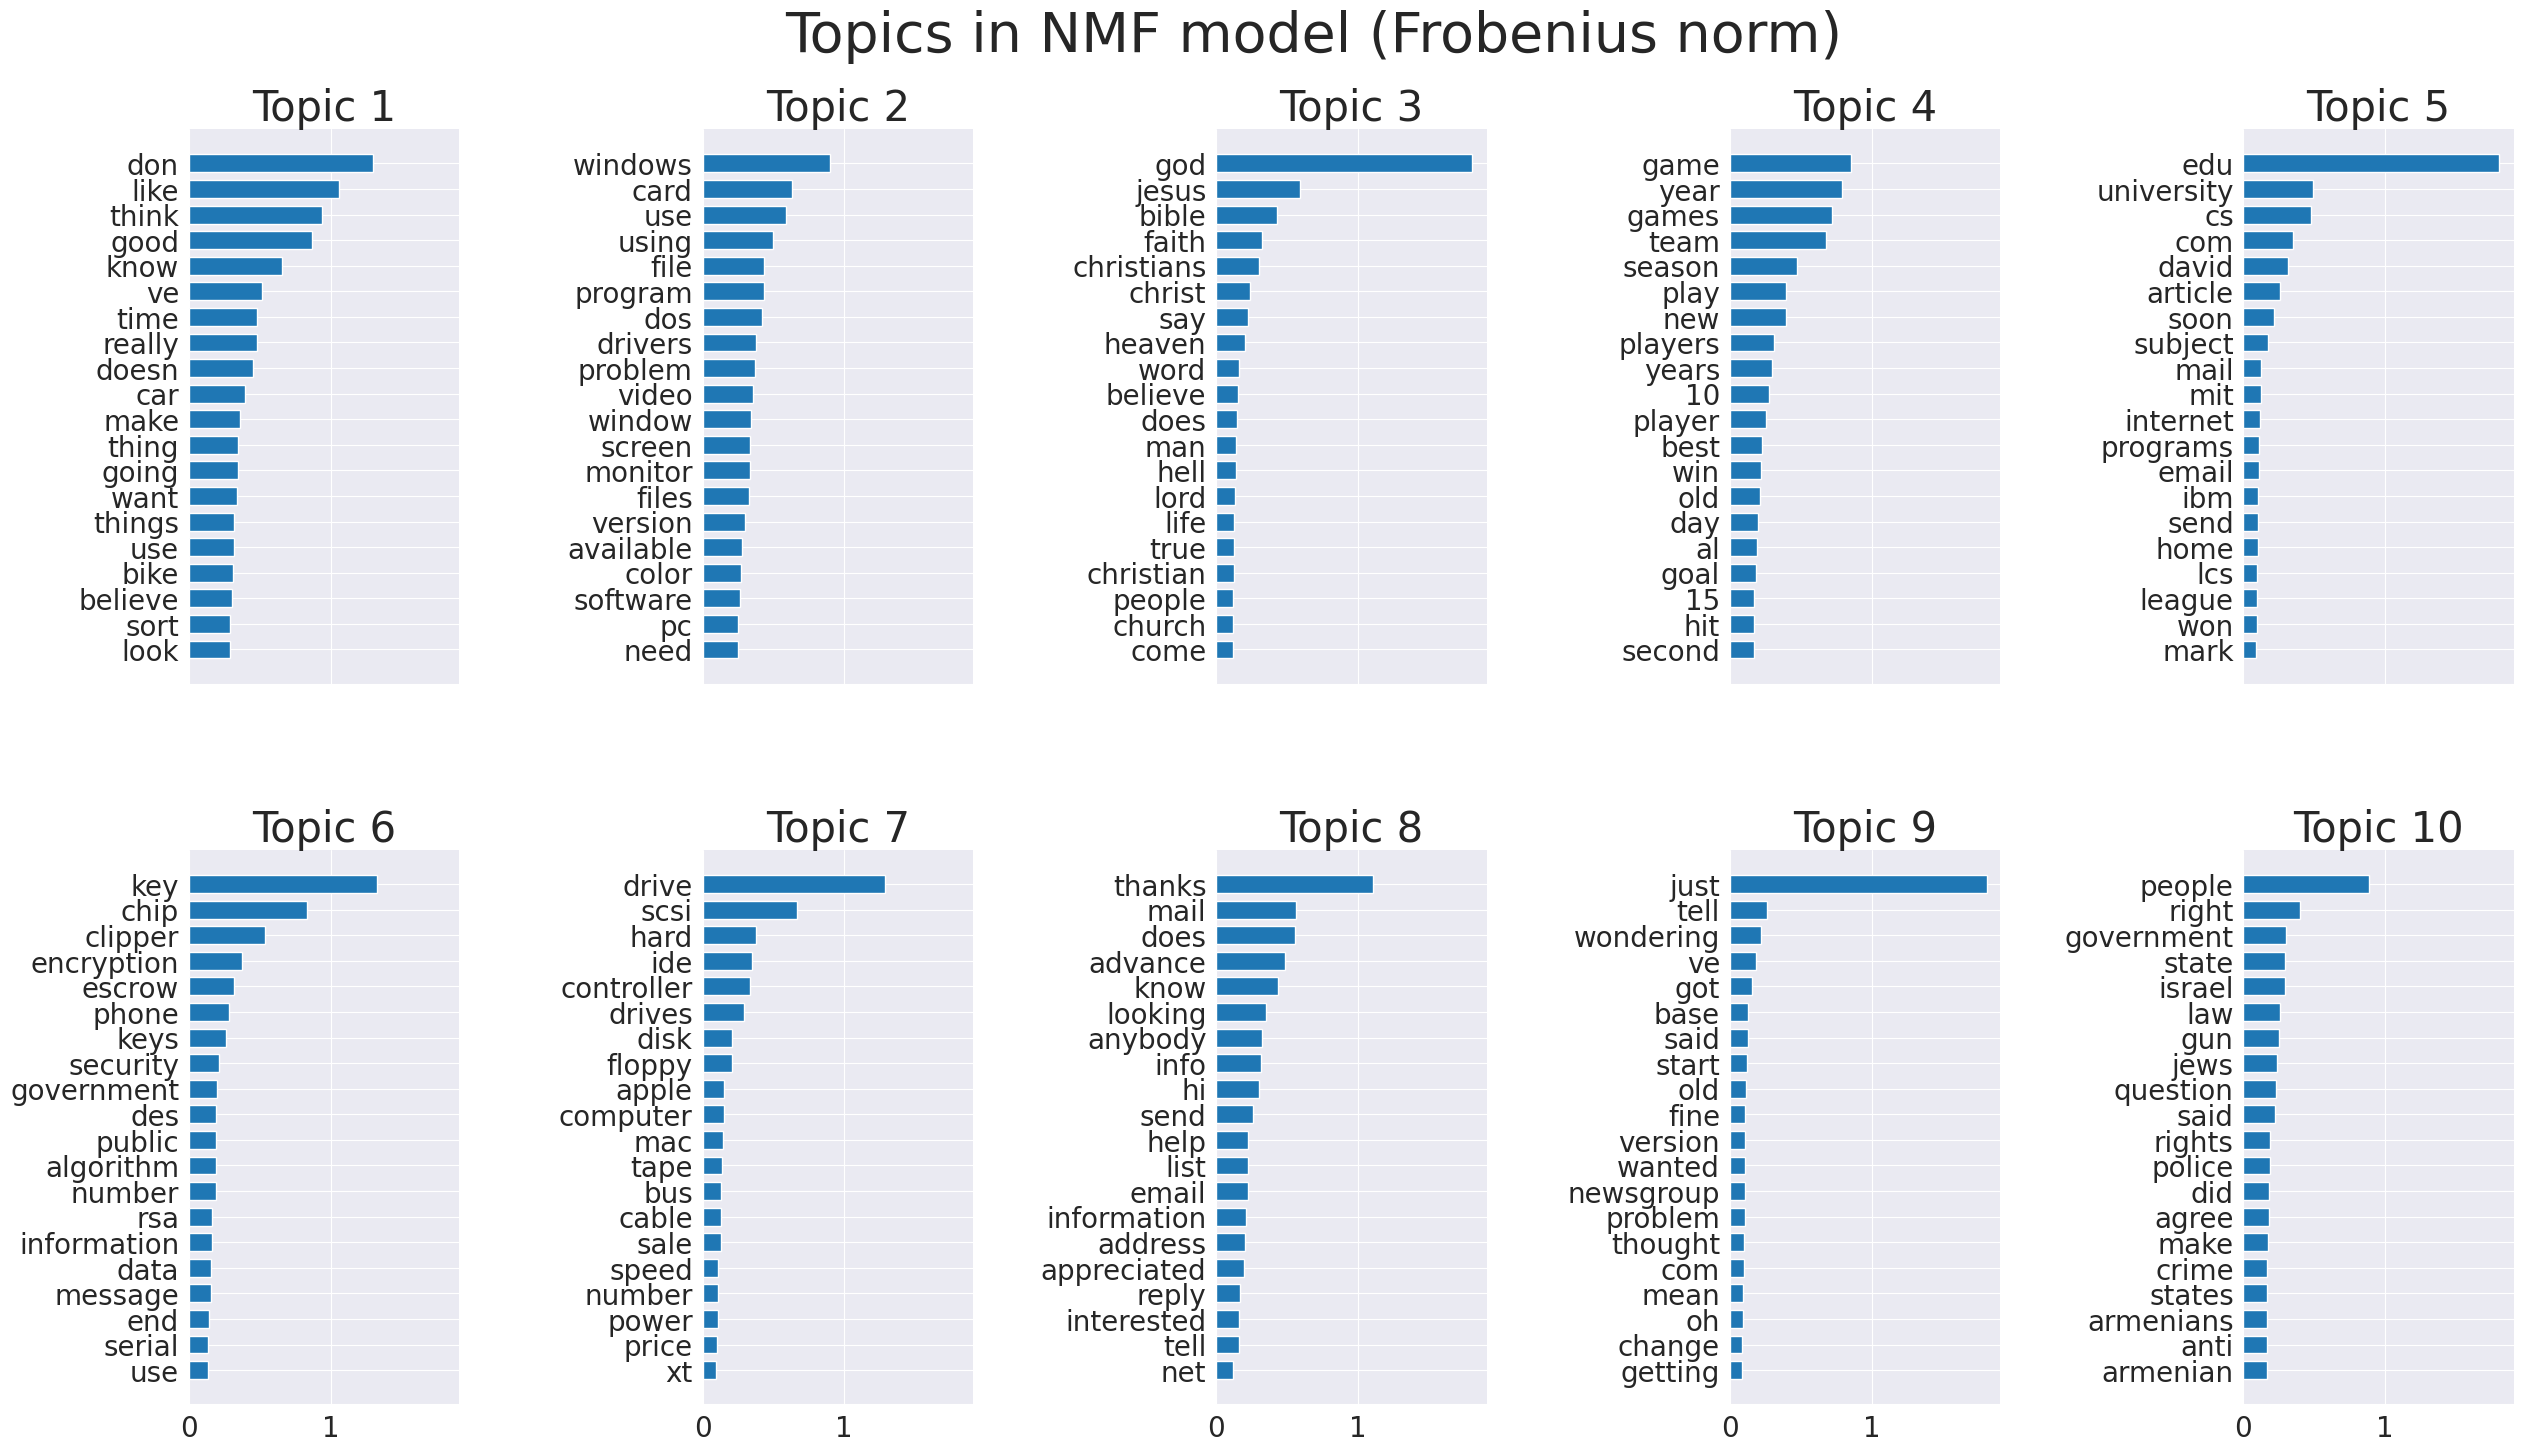

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

from fml5_helper_funcs import plot_top_words

newsgroup, _ = fetch_20newsgroups( shuffle=True, random_state = rng.integers( 321 ), 
                                   remove=("headers", "footers", "quotes"),
                                   return_X_y=True,
                                 )
n_samples    = 2000
n_features   = 1000
n_components = 10
n_top_words  = 20
batch_size   = 128
init         = "nndsvda"
news_samples = newsgroup[:n_samples]

tfidf_vectorizer = TfidfVectorizer( max_df  =0.95, min_df=2, max_features=n_features, stop_words="english" )
tfidf            = tfidf_vectorizer.fit_transform( news_samples )

nmf = NMF( n_components = n_components, random_state = rng.integers( 84321 ), init = init, beta_loss="frobenius", 
           l1_ratio=1
         ).fit(tfidf)

tfidf_feature_names_nmf = tfidf_vectorizer.get_feature_names()

plot_top_words( nmf, tfidf_feature_names_nmf, n_top_words, "Topics in NMF model (Frobenius norm)" )



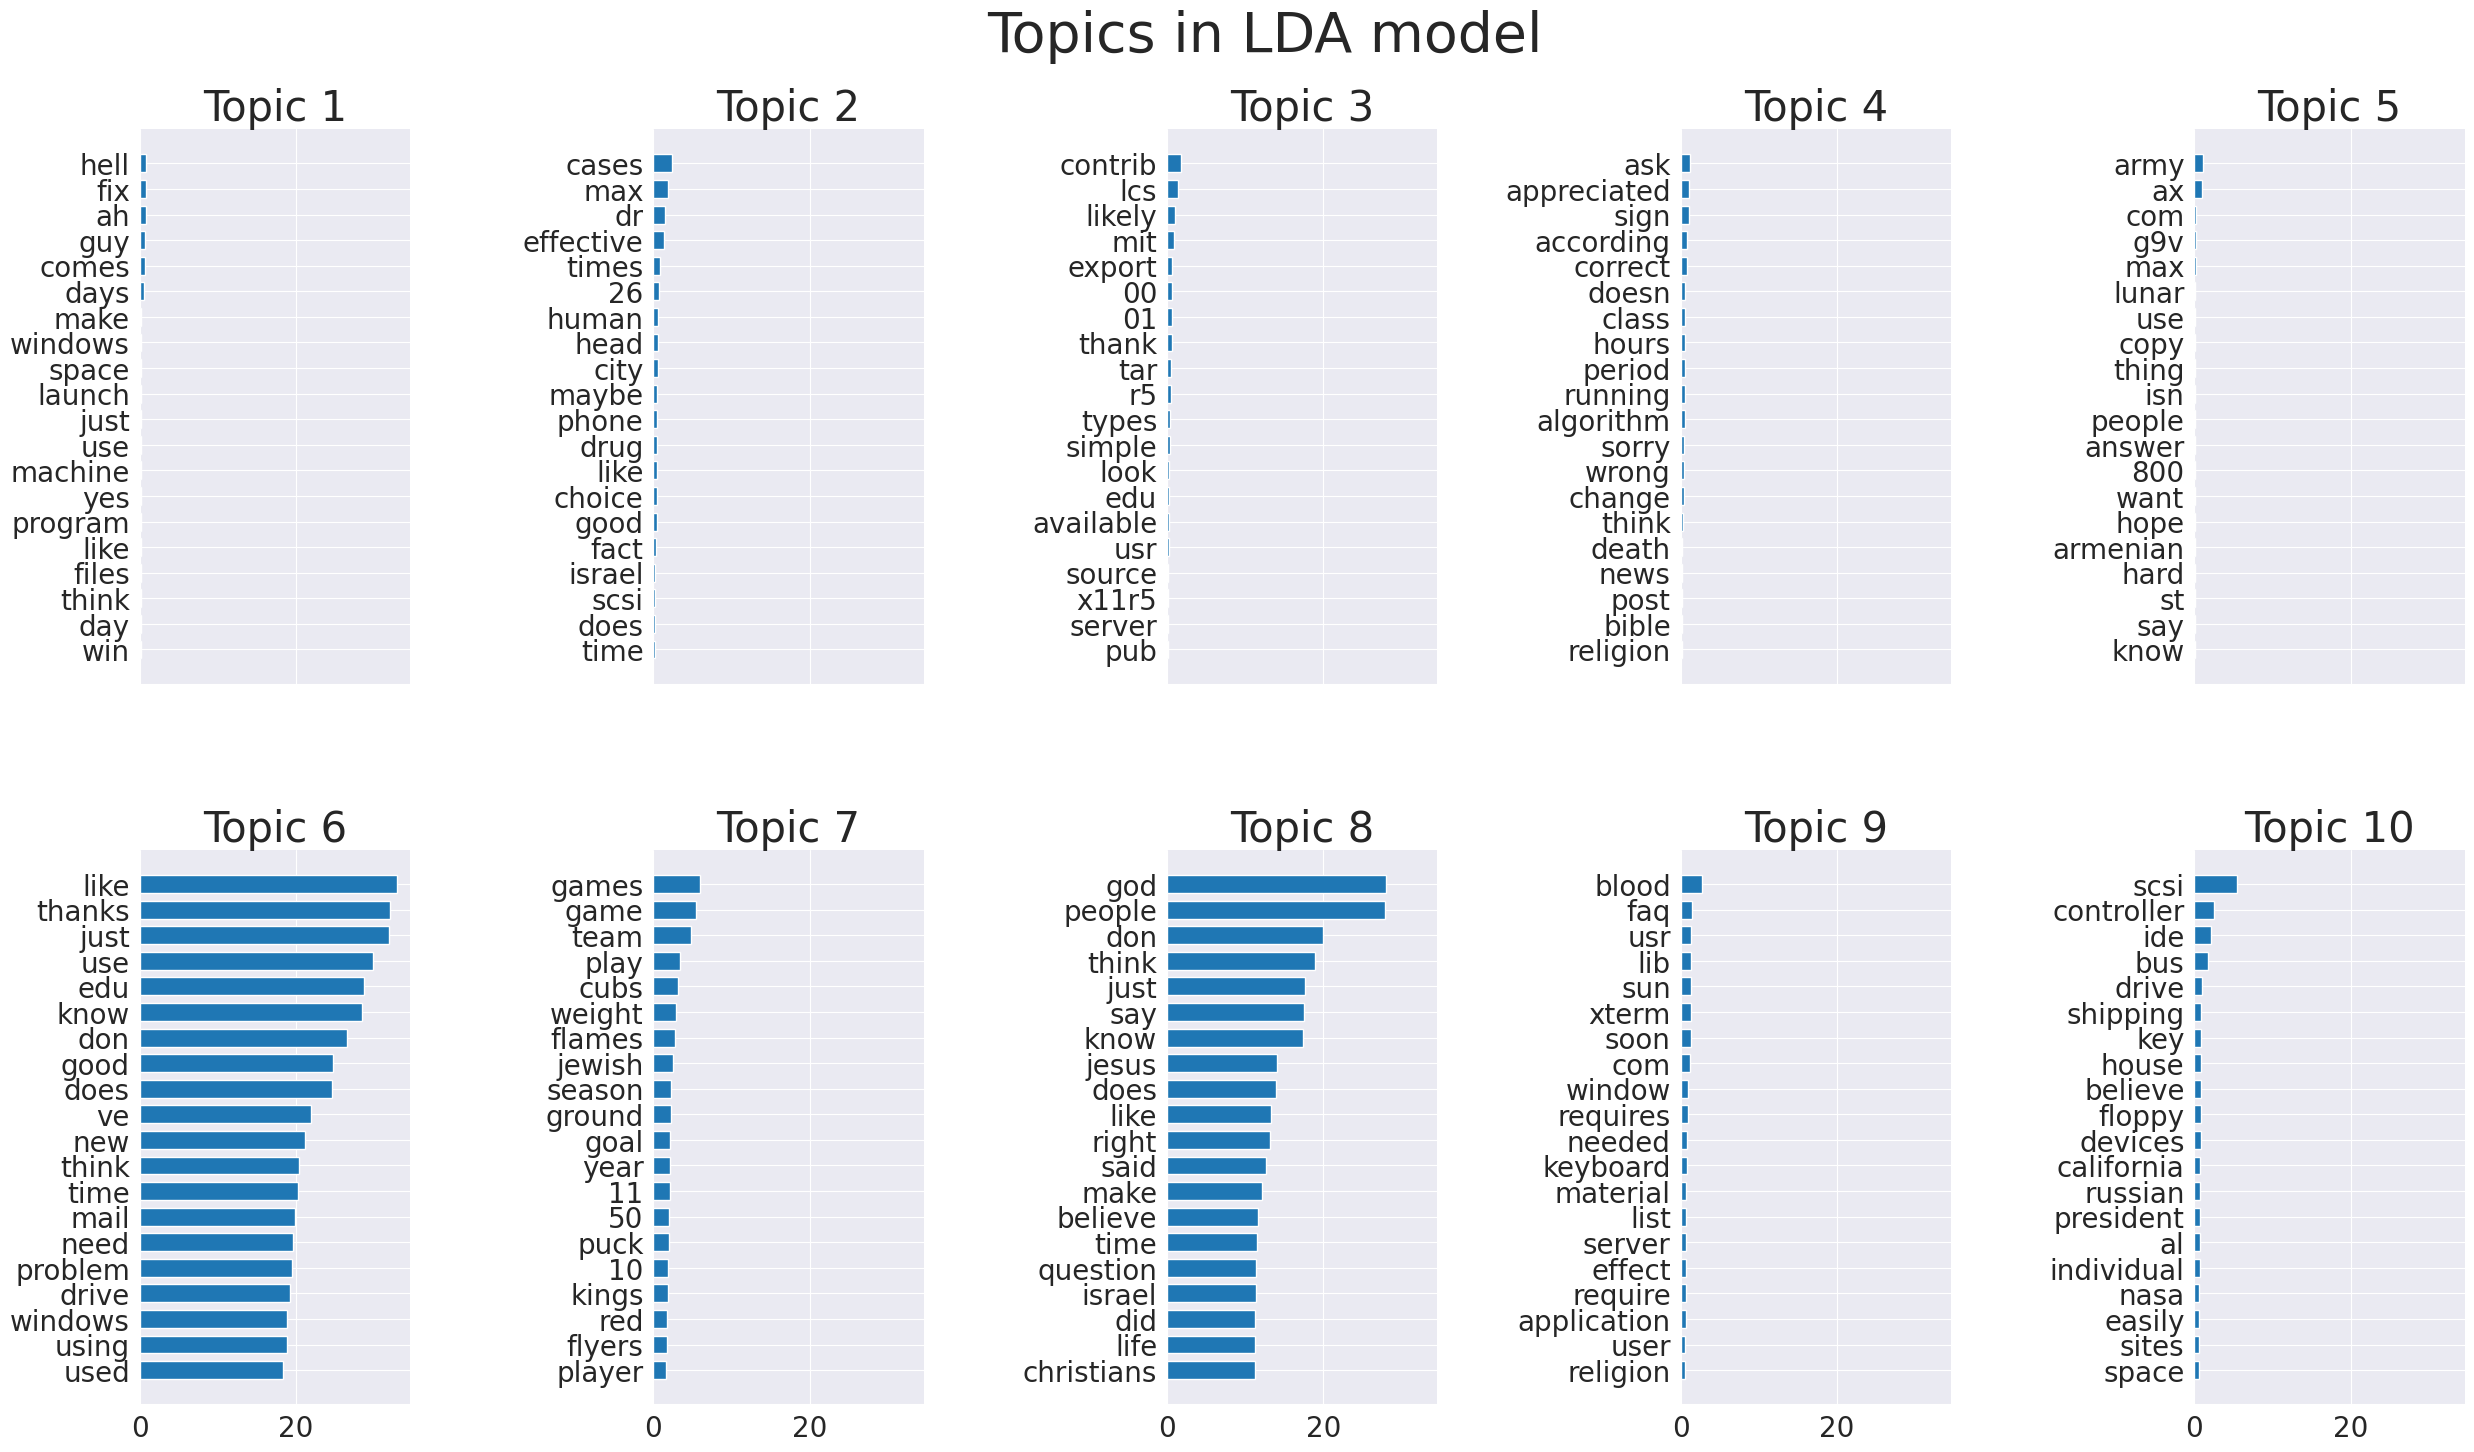

In [6]:
lda = LatentDirichletAllocation( n_components    = n_components, max_iter    = 5,
                                 learning_method = "online"    ,
                                 learning_offset = 50.0        , random_state = rng.integers( 854 ),
                               )
lda.fit( tfidf )

tfidf_feature_names_lda = tfidf_vectorizer.get_feature_names()

plot_top_words(lda, tfidf_feature_names_lda, n_top_words, "Topics in LDA model")

#### 3- Use PCA, t-SNE and Truncated SVD to create an embedding for the MNIST dataset. 

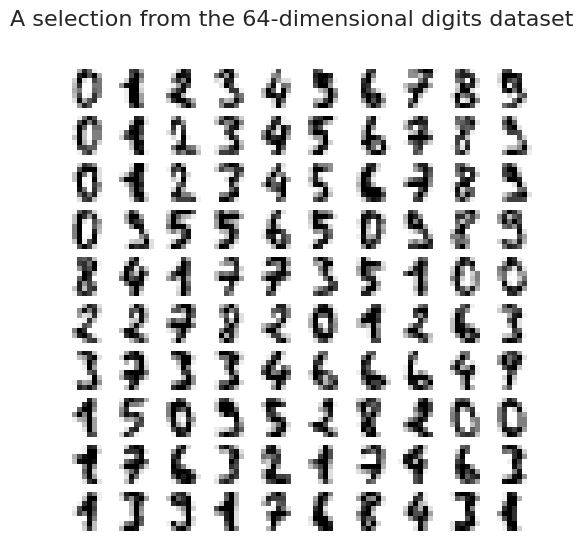

In [7]:
digits = data.load_digits()
X, y   = data.load_digits( return_X_y = True )

n_samples, n_features = X.shape
n_neighbors           = 30

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [8]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS, TSNE
from fml5_helper_funcs import plot_embedding

In [9]:
embeddings = { "Truncated SVD embedding": TruncatedSVD( n_components = 2 ),
               "MDS embedding"          : MDS( n_components = 2, n_init=1, max_iter=120, n_jobs=2),
               "PCA"                    : PCA( n_components = 2 )
            ,
            }

In [10]:
projections =  {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")

    projections[name] = transformer.fit_transform(X, y)

Computing Truncated SVD embedding...
Computing MDS embedding...
Computing PCA...


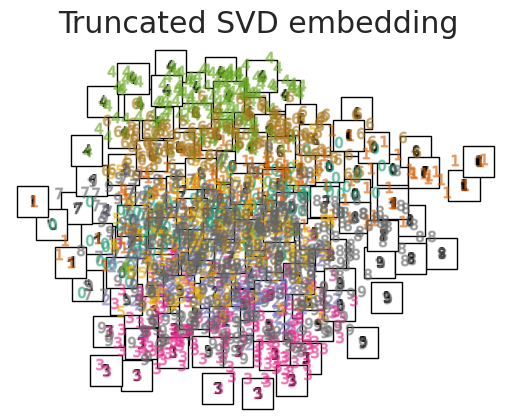

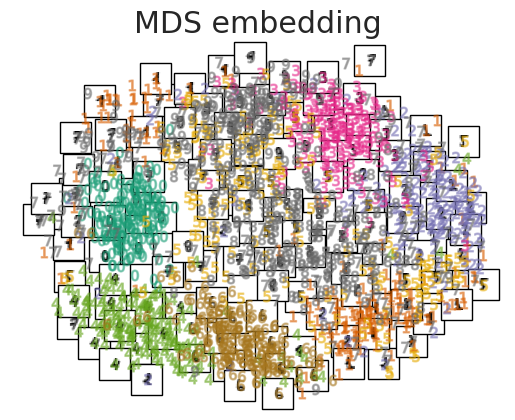

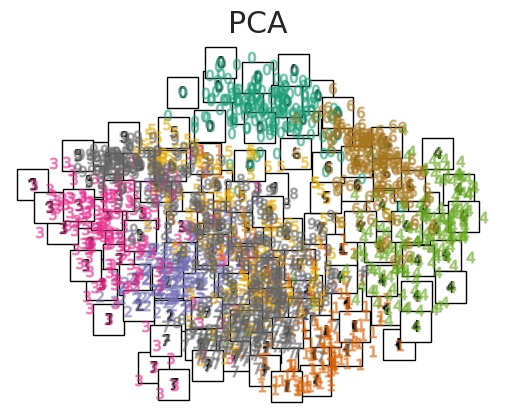

In [12]:
for name in projections:
    title = f"{name}"
    plot_embedding(projections[name], y, digits, title)

plt.show()